In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount = False)

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/Med dataset.zip'

Archive:  /content/drive/MyDrive/Med dataset.zip
   creating: Med dataset/Drive/
  inflating: Med dataset/Drive/drives1.png  
  inflating: Med dataset/Drive/drives10.png  
  inflating: Med dataset/Drive/drives100.png  
  inflating: Med dataset/Drive/drives101.png  
  inflating: Med dataset/Drive/drives102.png  
  inflating: Med dataset/Drive/drives103.png  
  inflating: Med dataset/Drive/drives104.png  
  inflating: Med dataset/Drive/drives105.png  
  inflating: Med dataset/Drive/drives106.png  
  inflating: Med dataset/Drive/drives107.png  
  inflating: Med dataset/Drive/drives108.png  
  inflating: Med dataset/Drive/drives109.png  
  inflating: Med dataset/Drive/drives11.png  
  inflating: Med dataset/Drive/drives110.png  
  inflating: Med dataset/Drive/drives111.png  
  inflating: Med dataset/Drive/drives112.png  
  inflating: Med dataset/Drive/drives113.png  
  inflating: Med dataset/Drive/drives114.png  
  inflating: Med dataset/Drive/drives115.png  
  inflating: Med dataset/Drive

In [ ]:
import os
import numpy as np

In [ ]:
pip install mediapipe


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 33.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [ ]:
import cv2
import mediapipe as mp
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, TimeDistributed
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def detect_pose(image):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose


    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)


        if results.pose_landmarks:
            keypoints = [(landmark.x, landmark.y) for landmark in results.pose_landmarks.landmark]


            return keypoints
        else:
            return None

In [ ]:
def extract_image_features(image):

    img = cv2.resize(image, (224, 224))
    x = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = x.astype('float32') / 255.0
    x = np.expand_dims(x, axis=0)


    model = VGG16(weights='imagenet', include_top=False)
    features = model.predict(x)

    return features

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

1/1 [==============================] - 0s 126ms/step
Number of images before processing: 3525
Number of features after processing: 2474
Number of labels after processing: 2474
Epoch 1/20
53/53 [==============================] - 2s 14ms/step - loss: 1.6268 - accuracy: 0.6088 - val_loss: 0.3451 - val_accuracy: 0.8855
Epoch 2/20
53/53 [==============================] - 0s 8ms/step - loss: 0.3428 - accuracy: 0.8775 - val_loss: 0.2140 - val_accuracy: 0.9327
Epoch 3/20
53/53 [==============================] - 0s 7ms/step - loss: 0.2070 - accuracy: 0.9322 - val_loss: 0.2018 - val_accuracy: 0.9259
Epoch 4/20
53/53 [==============================] - 0s 7ms/step - loss: 0.1238 - accuracy: 0.9673 - val_loss: 0.1445 - val_accuracy: 0.9461
Epoch 5/20
53/53 [==============================] - 0s 8ms/step - loss: 0.0907 - accuracy: 0.9738 - val_loss: 0.1175 - val_accuracy: 0.9663
Epoch 6/20
53/53 [==============================] - 0s 7ms/step - loss: 0.0841 - accuracy: 0.9780 - val_loss: 0.1632 - val_

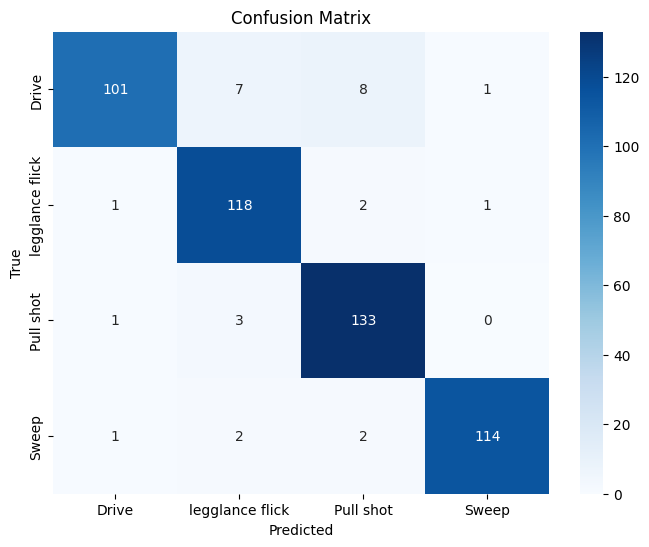

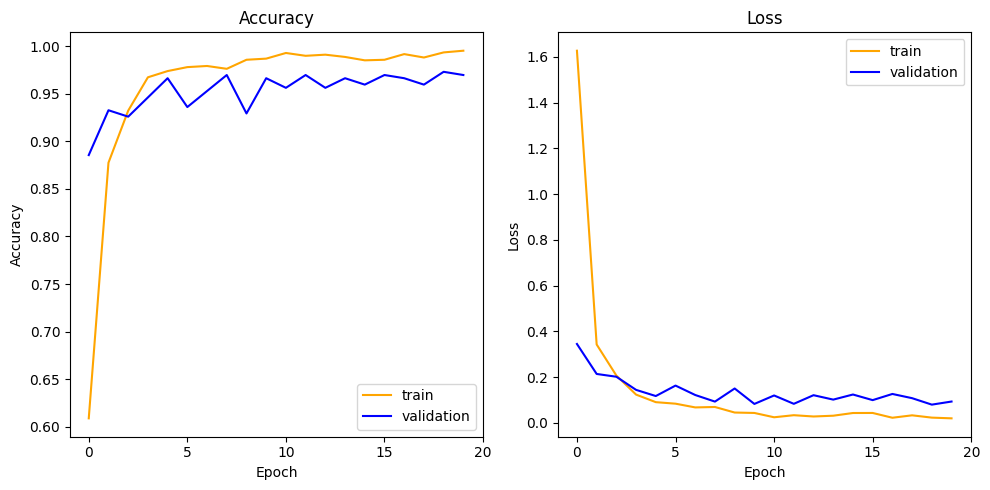

In [ ]:
def train_and_evaluate_model(shot_types, image_root_dir, num_classes, epochs=20, test_size=0.2, random_state=42):
    image_paths = []
    labels = []
    features = []

    for shot_type in shot_types:
        shot_path = os.path.join(image_root_dir, shot_type)
        for filename in os.listdir(shot_path):
            image_path = os.path.join(shot_path, filename)
            image_paths.append(image_path)

            label = np.zeros(len(shot_types))
            label[shot_types.index(shot_type)] = 1


            image = cv2.imread(image_path)
            keypoints = detect_pose(image)
            if keypoints is not None:

                image_features = extract_image_features(image)
                if image_features is not None:
                    combined_features = np.concatenate((keypoints, image_features), axis=None)
                    features.append(combined_features)
                    labels.append(label)
                else:

                    del image_paths[-1]

    print("Number of images before processing:", len(image_paths))
    print("Number of features after processing:", len(features))
    print("Number of labels after processing:", len(labels))

    features = np.array(features)
    labels = np.array(labels)


    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)


    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(features.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.15)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)


    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)


    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=shot_types, yticklabels=shot_types)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], c='orange')
    plt.plot(history.history['val_accuracy'], c='blue')
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.xticks([0, 5, 10, 15, 20])


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], c='orange')
    plt.plot(history.history['val_loss'], c='blue')
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.xticks([0, 5, 10, 15, 20])

    plt.tight_layout()
    plt.show()




    return model







shot_types = ["Drive", "legglance flick", "Pull shot", "Sweep"]
image_root_dir = "/content/Med dataset"
history=train_and_evaluate_model(shot_types, image_root_dir, len(shot_types))
